In [15]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests_cache
from mlfinlab.portfolio_optimization.modern_portfolio_theory import CriticalLineAlgorithm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)


DATE = 'Date'
HIGH = 'High'
LOW = 'Low'
OPEN = 'Open'
CLOSE = 'Close'
VOLUMN = 'Volume'
ADJ_CLOSE = 'Adj Close'
CODE = 'Code'

NUM_PORTFOLIOS = 5000
resoure = 'yahoo'
codes = ['AAPL', 'ADBE', 'ADI']
start_date = '2009/12/31'
end_date = '2020/11/30'

# Fetch Price
frames = []
for code in codes:
    r = data.DataReader(code, resoure, start=start_date, end=end_date, session=session)
    r[CODE] = code
    r = r[[ADJ_CLOSE, CODE]]
    frames.append(r)
    print(code)
total_prices = pd.concat(frames)
prices = total_prices.pivot(columns = CODE, values= ADJ_CLOSE)

# Sanitize Data
avg_returns = expected_returns.mean_historical_return(prices)
cov_mat = risk_models.sample_cov(prices)
# ef = EfficientFrontier(avg_returns, cov_mat)


strategy = 'max_sharpe'

cla = CriticalLineAlgorithm()
cla.allocate(expected_asset_returns=avg_returns,covariance_matrix=cov_mat,asset_names=codes,solution=strategy)
# cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)

cla_weights = cla.weights.loc[0].round(4)

print(cla_weights)

# means, sigma = cla.efficient_frontier_means, cla.efficient_frontier_sigma


# weights = cla_weights.loc[0]
# expected_returns = np.dot(weights,avg_returns)
# expected_sigma = np.sqrt(cla.min_var[0][0])

# risk_free_return = 0.02
# risk_free_sigma = 0

# max_slope = -1
# index = -1
# for i, (m, s) in enumerate(zip(means, sigma)):
#     slope = (m - risk_free_return)/(s-risk_free_sigma)
#     if slope >max_slope:
#         max_slope = slope
#         index = i
# print(index, max_slope)
# print(cla_weights.loc[index].round(4))
# print(cla_weights)
# print(means, sigma)


AAPL
ADBE
ADI
AAPL    0.671
ADBE    0.329
ADI     0.000
Name: 0, dtype: float64


In [16]:
cla_weights.loc[0,'XEL']

0.20550205281552913

In [1]:
%load_ext zipline

In [4]:
%%zipline --bundle=yahoo-bundle --start 2015-11-30 --end 2020-11-30 --capital-base 50000.0 -o max_sharpe_30_days.pkl  --benchmark-symbol QQQ

from zipline.api import symbol, symbols, record, order_target_percent, set_benchmark
from zipline.finance import commission
from zipline.errors import (
    CannotOrderDelistedAsset,
    SymbolNotFound
)
from zipline.assets import AssetFinder
import numpy as np 
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt
from mlfinlab.portfolio_optimization.modern_portfolio_theory import CriticalLineAlgorithm

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    # context.assets = symbols('AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','NVDA', 'ADBE')

    # codes = open("./nasdaq_symbols.txt", "r").read().split('\n') + open("./sp_symbols.txt", "r").read().split('\n')
    codes = open("./nasdaq.txt", "r").read().split('\n')
    codes = list(set(codes[0: min(600, len(codes))]))
    # context.assets = []

    found_codes =[]
    for code in codes:
        try:
            s = symbol(code)
            found_codes.append(code)
        except SymbolNotFound:
            pass
    
    context.assets = symbols(*found_codes)
    print("total symbols", len(context.assets))
    # context.bond = symbol('IGLB')
    context.bond = symbol('IGLB')

    # symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.window = 252
    context.rebalance_period = 60
    context.time = 0
    # set_benchmark(False)
    # set_benchmark(symbol('^IXIC'))
    context.stock_weight = 0.9

def handle_data(context, data):
    
    cleaned_weights = []
    tradable_assets = []
    untradable_assets = []
    
    if context.time == 0 or (context.time % context.rebalance_period == 0):

        # print(context.time)
        for asset in context.assets:
            if data.can_trade(asset):
                tradable_assets.append(asset)
            else:
                untradable_assets.append(asset)
        # extract prices
        prices = data.history(tradable_assets, fields='close',
                              bar_count=context.window + 1, frequency='1d').dropna()
        
        # calculate expected returns and sample covariance amtrix
        avg_returns = expected_returns.mean_historical_return(prices)
        cov_mat = risk_models.sample_cov(prices)

        # get weights maximizing the Sharpe ratio
        # ef = EfficientFrontier(avg_returns, cov_mat)
        # weights = ef.min_volatility()
        # cleaned_weights = ef.clean_weights()

        cleaned_weights = {}
        try:
            # strategy = 'min_volatility'
            # cla = CriticalLineAlgorithm()
            # cla.allocate(expected_asset_returns=avg_returns, covariance_matrix=cov_mat, asset_names=context.assets, solution=strategy)
            # cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)
            # cleaned_weights = cla_weights.loc[0].round(4)

            # expected_return = np.dot(avg_returns, cleaned_weights)

            strategy = 'max_sharpe'
            cla = CriticalLineAlgorithm(weight_bounds=(0, 0.3))
            cla.allocate(expected_asset_returns=avg_returns,covariance_matrix=cov_mat, asset_names=tradable_assets,solution=strategy)
            cla_weights = cla.weights
            
            cleaned_weights = cla_weights.loc[0].round(4)

        except Exception as e:
            print(e)
            # context.time += 1
            # return

        rest = 1.0
        for asset in tradable_assets:
            if data.can_trade(asset) and cleaned_weights[asset] >= 0:
                weight = context.stock_weight * cleaned_weights[asset]
                # if cleaned_weights[asset] > 0:
                    # print(asset, weight)
                order_target_percent(asset, weight)
                rest -= weight


                    # short_mavg = data.history(asset, 'price', bar_count=30, frequency="1d").mean()
                    # long_mavg = data.history(asset, 'price', bar_count=60, frequency="1d").mean()
                    # if cleaned_weights[asset] >= 0:
                    #     if short_mavg > long_mavg:
                    #         weight = context.stock_weight * cleaned_weights[asset]
                    #         order_target_percent(asset, weight)
                    #         rest -= weight
                    #     else:
                    #         order_target_percent(asset, 0)

                    # first = data.history(asset, 'price', bar_count=60, frequency="1d").first('3D').mean()
                    # last = data.history(asset, 'price', bar_count=60, frequency="1d").last('3D').mean()
                    # if cleaned_weights[asset] >= 0:
                    #     if (first-last) / first > 0.1:
                    #         print(first, last)
                    #         weight = context.stock_weight * cleaned_weights[asset]
                    #         order_target_percent(asset, weight)
                    #         rest -= weight
                    #     else:
                    #         order_target_percent(asset, 0)

                    # if expected_return < 0.02:
                    #     order_target_percent(asset, 0)
                    # elif short_mavg > long_mavg:
                    #     order_target_percent(asset, 0.7*cleaned_weights[asset])
                    # else:
                    #     order_target_percent(asset, 0)
        if data.can_trade(context.bond):
            order_target_percent(context.bond, min(rest, 0.4))
        
        # print("finish", context.time)
        print("\n")
    
    for asset in untradable_assets:
        cleaned_weights[asset] = 0.0
    record(weights=cleaned_weights)
    context.time += 1

    

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    plt.show()
    
    avg_returns = expected_returns.mean_historical_return(perf.portfolio_value)
    cov_mat = risk_models.sample_cov(perf.portfolio_value)

IndentationError: expected an indented block (<algorithm>, line 103)

In [36]:
%%zipline --start 2014-1-1 --end 2018-1-1 -o dma.pickle


from zipline.api import order_target, record, symbol, set_benchmark
import matplotlib.pyplot as plt

def initialize(context):
    context.i = 0
    context.asset = symbol('OXY')
    set_benchmark(True)


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=10, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=30, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

UsageError: Line magic function `%%zipline` not found.


In [110]:
from pandas_datareader import data
import requests_cache
import datetime

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
resoure = 'yahoo'
codes=['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 
'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 
'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 
'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 
'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 
'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 
'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 
'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 
'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 
'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 
'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 
'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 
'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 
'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 
'ETR', 'EOG', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EVRG', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD',
'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FRC', 'FISV', 'FLT', 'FLIR', 
'FLS', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 
'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'GWW', 'HAL', 'HBI', 'HIG', 'HAS', 'HCA', 'PEAK', 
'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HFC', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 
'HUM', 'HBAN', 'HII', 'IEX', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 
'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JKHY', 'J', 'JBHT', 'SJM', 
'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 
'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 
'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 
'MKC', 'MXIM', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 
'TAP', 'MDLZ', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NOV', 'NTAP', 'NFLX', 'NWL', 'NEM', 
'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NRG', 'NUE', 'NVDA', 
'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 
'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 
'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 
'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 
'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 
'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 
'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'FTI', 'TDY', 'TFX', 'TER', 'TXN', 'TXT', 
'TMO', 'TIF', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TFC', 'TWTR', 'TYL', 'TSN', 'UDR', 'ULTA', 
'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UHS', 'UNM', 'VLO', 'VAR', 'VTR', 'VRSN', 
'VRSK', 'VZ', 'VRTX', 'VFC', 'VIAC', 'VTRS', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WAB', 'WMT', 'WBA', 
'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW',
 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
# codes = ['TLT']
# ['QQQ']
# nasdaq=['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD','AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'BIDU', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CDW', 
# 'CERN', 'CHKP', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH',
# 'CTXS', 'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'EXPE', 'FAST', 'FB', 'FISV', 
# 'DOCU', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 
# 'JD', 'KDP', 'KHC', 'KLAC', 'LBTYA', 'LBTYK', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDLZ', 'MELI',
# 'MNST', 'MRNA', 'MSFT', 'MU', 'MXIM', 'NFLX', 'NTES', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PCAR', 
# 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'SWKS', 'TCOM', 
# 'TMUS', 'TSLA', 'TTWO', 'TXN', 'ULTA', 'VRSK', 'VRSN', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX', 'ZM']
start_date = '2000/12/31'
end_date = '2020/11/30'

for code in codes:
    try:
        df = data.DataReader(code, resoure, start=start_date, end=end_date, session=session)
        df = df.rename(str.lower, axis='columns')
        df['close'] = df['adj close']
        df.to_csv(f'./data/daily/{code}.csv')
    except:
        print(code)

BRK.B
BF.B


In [62]:
codes = ['ANSS','ATVI','ADBE','AMD','ALGN','ALXN','AMZN','AMGN','ADI','AAPL','AMAT','ASML','ADSK','ADP','BIDU','BIIB','BMRN','BKNG','CDNS','CDW','CERN','CHKP','CHTR','CPRT','CTAS','CSCO','CTXS',
'ATVI','ADBE','AMD','ALGN','ALXN','AMZN','AMGN','ADI','AAPL','AMAT','ASML','ADSK','ADP','BIDU','BIIB','BMRN','BKNG','CDNS','CDW','CERN','CHKP','CHTR','CPRT','CTAS','CSCO','CTXS',
'CMCSA','COST','CSX','CTSH','DOCU','DXCM','DLTR','EA','EBAY','EXC','EXPE','FAST','FB','FISV','FOX','FOXA','GILD','GOOG','GOOGL','ILMN','INCY','INTC','INTU','ISRG','IDXX','JD','KDP','KLAC','KHC',
'LRCX','LBTYA','LBTYK','LULU','MELI','MAR','MCHP','MDLZ','MRNA','MNST','MSFT','MU','MXIM','NFLX','NTES','NVDA','NXPI','ORLY','PAYX','PCAR','PDD','PYPL','PEP','QCOM','REGN','ROST','SIRI','SPLK','SWKS',
'SBUX','SNPS','TCOM','TTWO','TSLA','TXN','TMUS','ULTA','VRSN','VRSK','VRTX','WBA','WDAY','XEL','XLNX','ZM', 'ZM']

print (sorted(list(set(codes))))

['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'BIDU', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CDW', 'CERN', 'CHKP', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'DLTR', 'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'EXPE', 'FAST', 'FB', 'FISV', 'FOX', 'FOXA', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KDP', 'KHC', 'KLAC', 'LBTYA', 'LBTYK', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MRNA', 'MSFT', 'MU', 'MXIM', 'NFLX', 'NTES', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'SWKS', 'TCOM', 'TMUS', 'TSLA', 'TTWO', 'TXN', 'ULTA', 'VRSK', 'VRSN', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX', 'ZM']


In [34]:
import pandas as pd
import pyfolio as pf
results = pd.read_pickle('/Users/daniel/coding/max_sharpe_30_days.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')


In [112]:
codes = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD','AMGN', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'BIDU', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CDW', 
'CERN', 'CHKP', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH',
'CTXS', 'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'EXPE', 'FAST', 'FB', 'FISV', 
'DOCU', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 
'JD', 'KDP', 'KHC', 'KLAC', 'LBTYA', 'LBTYK', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDLZ', 'MELI',
'MNST', 'MRNA', 'MSFT', 'MU', 'MXIM', 'NFLX', 'NTES', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PCAR', 
'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'SWKS', 'TCOM', 
'TMUS', 'TSLA', 'TTWO', 'TXN', 'ULTA', 'VRSK', 'VRSN', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX', 'ZM'] + ['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 
'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 
'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 
'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 
'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 
'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 
'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 
'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 
'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 
'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 
'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 
'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 
'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 
'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 
'ETR', 'EOG', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EVRG', 'ES', 'RE', 'EXC', 'EXPE', 'EXPD',
'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FRC', 'FISV', 'FLT', 'FLIR', 
'FLS', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 
'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'GWW', 'HAL', 'HBI', 'HIG', 'HAS', 'HCA', 'PEAK', 
'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HFC', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 
'HUM', 'HBAN', 'HII', 'IEX', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 
'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JKHY', 'J', 'JBHT', 'SJM', 
'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 
'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 
'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 
'MKC', 'MXIM', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 
'TAP', 'MDLZ', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NOV', 'NTAP', 'NFLX', 'NWL', 'NEM', 
'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NRG', 'NUE', 'NVDA', 
'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 
'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 
'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 
'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 
'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 
'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 
'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'FTI', 'TDY', 'TFX', 'TER', 'TXN', 'TXT', 
'TMO', 'TIF', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TFC', 'TWTR', 'TYL', 'TSN', 'UDR', 'ULTA', 
'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UHS', 'UNM', 'VLO', 'VAR', 'VTR', 'VRSN', 
'VRSK', 'VZ', 'VRTX', 'VFC', 'VIAC', 'VTRS', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WAB', 'WMT', 'WBA', 
'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW',
 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
print(list(set(codes)))

['ROST', 'DLTR', 'LRCX', 'AXP', 'WU', 'ABBV', 'ASML', 'MAA', 'RCL', 'V', 'PPG', 'DFS', 'VAR', 'CHRW', 'LBTYK', 'LEG', 'NWS', 'OXY', 'PLD', 'WAB', 'D', 'MO', 'WYNN', 'NOC', 'CSCO', 'DHI', 'DOV', 'WRB', 'ORLY', 'RE', 'EBAY', 'FCX', 'EL', 'FOX', 'XRAY', 'ETSY', 'GPS', 'RF', 'TEL', 'PCAR', 'MELI', 'ADM', 'FITB', 'EW', 'IPGP', 'CB', 'STT', 'APA', 'EVRG', 'TMO', 'DIS', 'AJG', 'ALB', 'LEN', 'UAA', 'CMA', 'TER', 'UNP', 'OKE', 'NLSN', 'VZ', 'NOV', 'ADSK', 'BLK', 'AMT', 'NWSA', 'EQIX', 'LNC', 'ADP', 'BK', 'COO', 'NTAP', 'PEP', 'AMCR', 'KMX', 'ARE', 'A', 'SHW', 'TMUS', 'J', 'DISCK', 'CPRT', 'XEL', 'LDOS', 'WDC', 'SYF', 'XRX', 'CMI', 'FDX', 'ORCL', 'DXC', 'BEN', 'AAPL', 'JCI', 'MCK', 'TAP', 'ULTA', 'PNW', 'RJF', 'CVX', 'HBI', 'OTIS', 'FRT', 'PKG', 'SO', 'BA', 'CE', 'IVZ', 'LIN', 'MKC', 'PFE', 'BAX', 'CLX', 'DISH', 'AON', 'LYV', 'IR', 'MA', 'NOW', 'ITW', 'IPG', 'ILMN', 'POOL', 'IDXX', 'GM', 'DRI', 'KIM', 'EXPE', 'ODFL', 'MPC', 'NEM', 'MNST', 'TT', 'PSX', 'WMB', 'AMGN', 'PEAK', 'JPM', 'ZBRA', 'ABT',

In [126]:
codes = open("./sp_nasdaq_symbols.txt", "r").read().split('\n')
print(len(codes))

521


In [20]:
import requests
codes = open("./sp_symbols.txt", "r").read().split('\n')
codes = list(set(codes))
for code in codes:
    url = f"https://fmpcloud.io/api/v3/key-metrics-ttm/{code}?limit=40&apikey=9ad6a869ff2a758098fcec5b66268367"
    r = requests.get(url)
    with open(f"/Users/daniel/coding/data/metric/{code}.json", 'wb') as f:
        f.write(r.content)
        

In [2]:
import json
codes = open("./sp_symbols.txt", "r").read().split('\n')
codes = list(set(codes))
total = {}
columns = []
for code in codes:
    with open(f"/Users/daniel/coding/data/metric/{code}.json") as f:
        data = json.load(f)
        try:
            if "Error Message" not in data and "error" not in data:
                da = data[0]
                if len(columns) == 0 :
                    columns = da.keys()
                l = []
                for col in columns:
                    l.append(da[col])
                total[code] = l
        except:
            print(code)

In [3]:
import pandas as pd
print(list(columns))
col_mapping = {}
cols = list(columns)
for i in range(0, len(cols)):
    col_mapping[i] = cols[i]
print(col_mapping)
pd_data = pd.DataFrame.from_dict(total, orient='index').rename(columns=col_mapping)

['revenuePerShareTTM', 'netIncomePerShareTTM', 'operatingCashFlowPerShareTTM', 'freeCashFlowPerShareTTM', 'cashPerShareTTM', 'bookValuePerShareTTM', 'tangibleBookValuePerShareTTM', 'shareholdersEquityPerShareTTM', 'interestDebtPerShareTTM', 'marketCapTTM', 'enterpriseValueTTM', 'peRatioTTM', 'priceToSalesRatioTTM', 'pocfratioTTM', 'pfcfRatioTTM', 'pbRatioTTM', 'ptbRatioTTM', 'evToSalesTTM', 'enterpriseValueOverEBITDATTM', 'evToOperatingCashFlowTTM', 'evToFreeCashFlowTTM', 'earningsYieldTTM', 'freeCashFlowYieldTTM', 'debtToEquityTTM', 'debtToAssetsTTM', 'netDebtToEBITDATTM', 'currentRatioTTM', 'interestCoverageTTM', 'incomeQualityTTM', 'dividendYieldTTM', 'dividendYieldPercentageTTM', 'payoutRatioTTM', 'salesGeneralAndAdministrativeToRevenueTTM', 'researchAndDevelopementToRevenueTTM', 'intangiblesToTotalAssetsTTM', 'capexToOperatingCashFlowTTM', 'capexToRevenueTTM', 'capexToDepreciationTTM', 'stockBasedCompensationToRevenueTTM', 'grahamNumberTTM', 'roicTTM', 'returnOnTangibleAssetsTTM',

In [4]:
pd_data

,revenuePerShareTTM,netIncomePerShareTTM,operatingCashFlowPerShareTTM,freeCashFlowPerShareTTM,cashPerShareTTM,bookValuePerShareTTM,tangibleBookValuePerShareTTM,shareholdersEquityPerShareTTM,interestDebtPerShareTTM,marketCapTTM,...,averagePayablesTTM,averageInventoryTTM,daysSalesOutstandingTTM,daysPayablesOutstandingTTM,daysOfInventoryOnHandTTM,receivablesTurnoverTTM,payablesTurnoverTTM,inventoryTurnoverTTM,roeTTM,capexPerShareTTM
AEP,30.077716,3.865750,1.854577,-1.603457,0.825712,41.045555,158.590879,41.045555,59.520579,4.131674e+10,...,1.643800e+09,1.273550e+09,11.160823,18.349386,14.011916,8.063922,4.904796,6.423104,0.094182,-3.458033
VTR,10.349930,0.911474,0.949241,0.330192,1.576579,27.324439,61.551015,27.324439,33.616911,1.830060e+10,...,1.116560e+09,NaN,18.093599,56.786100,0.000000,4.974135,1.584895,NaN,0.033357,-0.619049
FFIV,38.444161,5.027736,2.355100,1.990351,13.893212,36.505388,72.806097,36.505388,11.927914,1.075856e+10,...,5.943050e+07,2.836200e+07,16.626146,14.225705,6.155675,5.413161,6.326576,14.620654,0.137726,-0.364748
STT,30.665300,7.028115,13.394594,12.749995,271.813424,70.630429,790.352030,70.630429,206.623750,2.562999e+10,...,NaN,NaN,46.762663,NaN,NaN,1.924612,NaN,NaN,0.099505,-0.644599
LH,127.742300,8.674538,5.850103,4.533881,6.850103,84.590349,152.146817,84.590349,57.913758,1.982577e+10,...,5.868000e+08,3.674000e+08,19.521062,6.713128,4.120254,4.610405,13.406568,21.843312,0.102548,-1.316222
CAH,527.802048,3.320819,2.378840,2.116041,9.372014,4.853242,132.819113,4.853242,23.703072,1.569308e+10,...,2.153100e+10,1.331850e+10,5.026512,13.211680,8.186636,17.905060,6.812154,10.993526,0.684248,-0.262799
TWTR,4.343110,-1.566675,0.350493,0.158776,2.783255,9.878378,16.476257,9.878378,10.331577,4.282328e+10,...,2.016310e+08,NaN,19.588412,17.394523,0.000000,4.594553,5.174043,NaN,-0.158596,-0.191717
SNA,68.523897,10.821691,12.400735,10.573529,14.476103,66.525735,110.772059,66.525735,27.136029,9.310016e+09,...,1.961000e+08,7.742000e+08,14.942458,10.413975,38.642925,6.023106,8.642233,2.329016,0.162669,-1.827206
TIF,30.219934,2.368204,3.354201,2.311367,9.437397,26.912685,57.127677,26.912685,7.649918,1.595803e+10,...,4.169000e+08,2.497750e+09,4.913730,28.366060,160.283073,18.316026,3.172806,0.561507,0.087996,-1.042834
LHX,85.423256,6.153488,3.990698,3.576744,6.237209,99.130233,127.590698,99.130233,3.841860,4.063930e+10,...,1.150500e+09,8.765000e+08,0.000000,8.286673,6.137768,NaN,10.860812,14.663311,0.062075,-0.413953


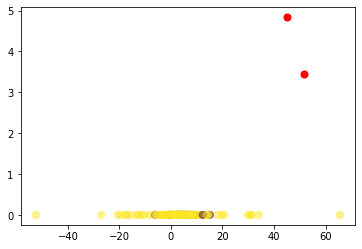

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
df = pd_data.fillna(-1)
kmeans = KMeans(n_clusters=2).fit(df)
centroids = kmeans.cluster_centers_
df['dummy'] = 0
df
plt.scatter(df['netIncomePerShareTTM'], df['dummy'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [1]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns